In [ ]:
# Importing libraries

import warnings
warnings.filterwarnings('ignore')
from typing import Tuple, Dict
import pickle
import torch.nn as nn
import torch
import segmentation_models_pytorch as sm
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob
import tifffile
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# import umap
import umap.umap_ as umap
import seaborn as sns
from sklearn.manifold import MDS

In [ ]:
# This step is done to carry out same preprocessing done while training the pretrained efficientnet-b2 on imagenet dataset
def preprocessing_fucntion(preprocesing_function=None):
    """
    This method carries out preprocessing done while training the pretrained efficientnet-b2 on imagenet dataset
    
    args:None
    
    Returns: Preprocessed image
    """
    return A.Compose([A.Lambda(image=preprocesing_function),ToTensorV2()])
preprocess  =preprocessing_fucntion(sm.encoders.get_preprocessing_fn("efficientnet-b2","imagenet"))

In [ ]:
# Last layer weights in encoder is used to get feature representation fo both train and test data
def generate_feature_maps(model:torch.nn):
    """
    This method is used to get feature representation fo both train and test data
    Reference: Adapted from https://github.com/j-sripad/colon_crypt_segmentation
    
    args: 
    model= fold_1_UNET.pth (Saved model weights to obtain feature maps)
    
    Returns: Train features, Train labels, Test features, Test labels
    """
    
    train_images = glob.glob("train/*.tiff")
    test_images = glob.glob("test/*.tiff")
    feature_maps_train = []
    tile_labels_train = []
    patch_size = (512,512)
    for image_name in train_images:
        im = tifffile.imread(image_name)
        mask = tifffile.imread(image_name.replace("train","train_mask"))
        model.eval()
        
        with torch.no_grad():
            cx,cy = 0,0
            max_height = im.shape[0]
            max_width = im.shape[1]
            feature = []
            feature_label = []
            while cy+patch_size[0] <= max_height: 

                while cx+patch_size[1] <= max_width:
                    data = image[cy:cy+patch_size[0],cx:cx+patch_size[1]]
                    data_img = preprocess(image = data)['image'].unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")
                    feature.append(model.encoder(data_img.float())[5].flatten().detach().cpu().numpy())  
                    feature_label.append(np.max((np.array(mask[cy:cy+patch_size[0],cx:cx+patch_sizee[1]],dtype=int)>0)*1))  
                    cx+=patch_size[1]
                cy+=patch_size[0]
                cx=0
        
        feature_maps_train.extend(features)
        tile_labels_train.extend(labels)
        
    feature_maps_test = []
    tile_labels_test = []
    for image_name in test_images:
        im = tifffile.imread(image_name)
        mask = tifffile.imread(image_name.replace("test","test_mask"))
        model.eval()
        
        with torch.no_grad():
            cx,cy = 0,0
            max_height = im.shape[0]
            max_width = im.shape[1]
            feature = []
            feature_label = []
            while cy+patch_size[0] <= max_height: 

                while cx+patch_size[1] <= max_width:
                    data = image[cy:cy+patch_size[0],cx:cx+patch_size[1]]
                    data_img = preprocess(image = data)['image'].unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")
                    feature.append(model.encoder(data_img.float())[5].flatten().detach().cpu().numpy())  
                    feature_label.append(np.max((np.array(mask[cy:cy+patch_size[0],cx:cx+patch_sizee[1]],dtype=int)>0)*1))  
                    cx+=patch_size[1]
                cy+=patch_size[0]
                cx=0
        
        
        feature_maps_test.extend(features)
        tile_labels_test.extend(labels)
        
    return feature_maps_train,tile_labels_train,feature_maps_test,tile_labels_test

In [ ]:
# Used UNet with efficientnet-b2 as encoder
model = sm.Unet(encoder_name="efficientnet-b2",                
                     in_channels=3, 
                     classes=2)

model.to("cuda" if torch.cuda.is_available() else "cpu")

# We will use saved model weights to obtain feature maps
model.load_state_dict(torch.load("model/fold_1_UNET.pth"))

<All keys matched successfully>

In [ ]:
feature_representations = generate_feature_maps(model)

Shaped series: axes do not match shape
Shaped series: axes do not match shape
Shaped series: axes do not match shape
Shaped series: axes do not match shape
Shaped series: axes do not match shape
Shaped series: axes do not match shape
Shaped series: axes do not match shape


In [ ]:
with open("feature_maps.pkl", 'wb') as f:
    pickle.dump(feature_representations, f)

In [ ]:
# loading feature representations

with open("feature_maps.pkl" ,'rb') as f:
    feature_representations = pickle.load(f)
train_features,train_labels,test_features,test_labels = feature_representations[0],feature_representations[1],feature_representations[2],feature_representations[3]

In [ ]:
feature_representations

([array([  2.3638506,   2.9128528,   2.5505247, ...,   2.2968926,
           5.137465 , -17.20814  ], dtype=float32),
  array([  3.154725 ,   3.4096043,   2.8182416, ...,   2.0718596,
           2.5430355, -18.8541   ], dtype=float32),
  array([ -0.6500732,  -1.5247053,  -1.3809335, ...,   1.1347361,
           1.8732314, -23.60276  ], dtype=float32),
  array([-1.2187233, -1.5513197, -1.6469858, ..., -3.587849 , -6.834218 ,
         -7.7939963], dtype=float32),
  array([-4.0442185, -4.0332365, -4.751425 , ...,  4.495141 , -0.8968824,
         -0.9454812], dtype=float32),
  array([ -2.1602697,  -1.9587346,  -3.5196545, ...,  -2.707203 ,
          -4.202611 , -12.605309 ], dtype=float32),
  array([ -3.0876522,  -3.3732238,  -3.451195 , ...,  13.806949 ,
           8.892929 , -10.380125 ], dtype=float32),
  array([-3.9734573, -3.5554726, -3.1294935, ..., -3.575178 , -1.5467069,
         -1.5864937], dtype=float32),
  array([-2.7997718, -2.213182 , -1.9756876, ...,  1.3130016,  3.0962274,


In [ ]:

colors_set = ['tab:pink', 'tab:green']

In [ ]:
# Calcualte 
train_features_norm = (train_features - np.min(train_features))/ (np.max(train_features) - np.min(train_features))
test_features_norm = (test_features - np.min(test_features))/ (np.max(test_features) - np.min(test_features))
pca = PCA(n_components=2).fit(train_features_norm)
train_data_transformed = pca.transform(train_features_norm)
test_data_transformed =pca.transform(test_features_norm)

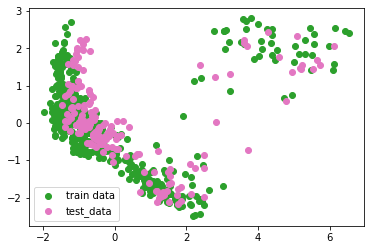

In [ ]:
# PCA
plt.scatter(train_data_transformed[:,0],train_data_transformed[:,1],label="train data",c=colors_set[1])
plt.scatter(test_data_transformed[:,0],test_data_transformed[:,1],label="test_data",c=colors_set[0])
plt.legend()
plt.show()


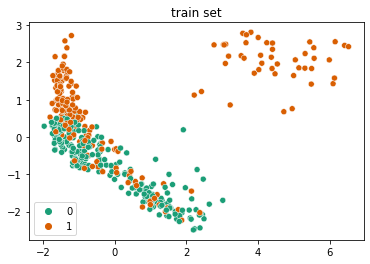

In [ ]:
# PCA for train dataset
sns.set_palette("Dark2")
sns.scatterplot(x = train_data_transformed[:,0],y = train_data_transformed[:,1],hue=train_labels).set(title="train set")


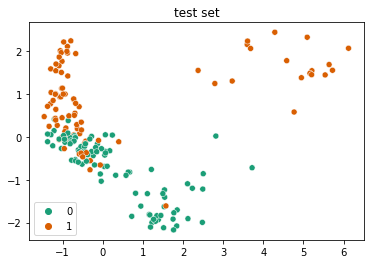

In [ ]:
# PCA for test dataset
sns.scatterplot(x =test_data_transformed[:,0],y = test_data_transformed[:,1],hue=test_labels).set(title="test set")


In [ ]:
# Compute TSNE
train_data_transformed_TSNE = TSNE(verbose=1,random_state=9,perplexity=50).fit_transform(train_features_norm)
test_data_transformed_TSNE =TSNE(verbose=1,random_state=0,perplexity=50).fit_transform(test_features_norm)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 450 samples in 0.041s...
[t-SNE] Computed neighbors for 450 samples in 1.765s...
[t-SNE] Computed conditional probabilities for sample 450 / 450
[t-SNE] Mean sigma: 1.701974
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.624367
[t-SNE] KL divergence after 1000 iterations: 0.934454
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 180 samples in 0.017s...
[t-SNE] Computed neighbors for 180 samples in 0.704s...
[t-SNE] Computed conditional probabilities for sample 180 / 180
[t-SNE] Mean sigma: 2.107737
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.155045
[t-SNE] KL divergence after 1000 iterations: 1.025627


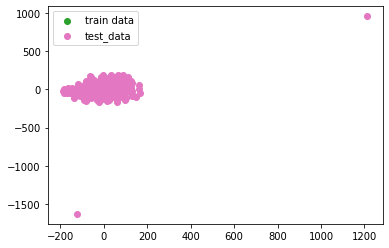

In [ ]:
# TSNE
plt.scatter(train_data_transformed_TSNE[:,0],train_data_transformed_TSNE[:,1],label="train data",c=colors_set[1])
plt.scatter(test_data_transformed_TSNE[:,0],test_data_transformed_TSNE[:,1],label="test_data",c=colors_set[0])
plt.legend()

plt.show()

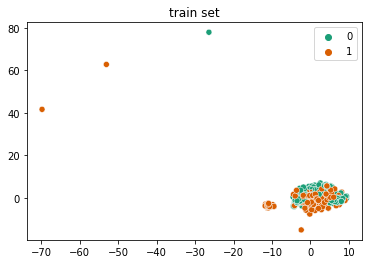

In [ ]:
# TSNE for Train dataset
sns.scatterplot(x = train_data_transformed_TSNE[:,0],y = train_data_transformed_TSNE[:,1],hue=train_labels).set(title="train set")


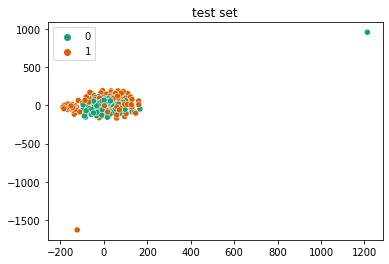

In [ ]:
# TSNE for test dataset
sns.scatterplot(x =test_data_transformed_TSNE[:,0],y = test_data_transformed_TSNE[:,1],hue=test_labels).set(title="test set")


In [ ]:
# UMAP 
um = umap.UMAP().fit(train_features_norm)
train_data_transformed_um = um.transform(train_features_norm)
test_data_transformed_um =um.transform(test_features_norm)

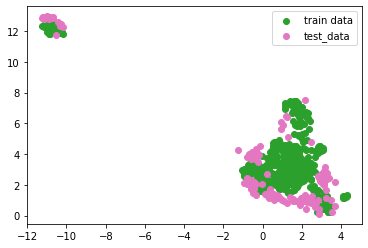

In [ ]:
# UMAP
plt.scatter(train_data_transformed_um[:,0],train_data_transformed_um[:,1],label="train data",c=colors_set[1])
plt.scatter(test_data_transformed_um[:,0],test_data_transformed_um[:,1],label="test_data",c=colors_set[0])
plt.legend()

plt.show()


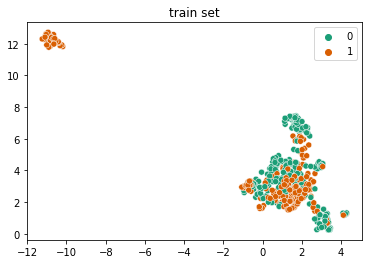

In [ ]:
# UMAP for train dataset
sns.scatterplot(x = train_data_transformed_um[:,0],y = train_data_transformed_um[:,1],hue=train_labels).set(title="train set")


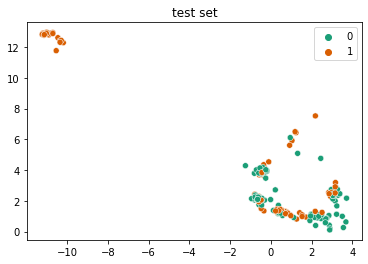

In [ ]:
# UMAP for test dataset
sns.scatterplot(x =test_data_transformed_um[:,0],y = test_data_transformed_um[:,1],hue=test_labels).set(title="test set")


In [ ]:
# MDS
train_data_transformed_MDS =  MDS(verbose=1,random_state=0).fit_transform(train_features_norm)
test_data_transformed_MDS = MDS(verbose=1,random_state=0).fit_transform(test_features_norm)

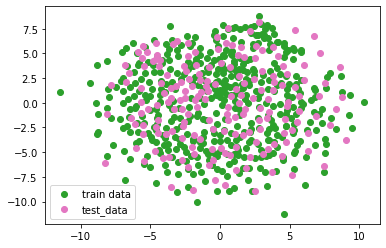

In [ ]:
# MDS
plt.scatter(train_data_transformed_MDS[:,0],train_data_transformed_MDS[:,1],label="train data",c=colors_set[1])
plt.scatter(test_data_transformed_MDS[:,0],test_data_transformed_MDS[:,1],label="test_data",c=colors_set[0])
plt.legend()

plt.show()

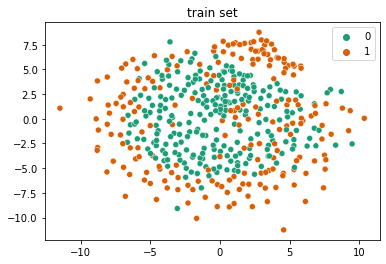

In [ ]:
# MDS for train dataset 
sns.scatterplot(x = train_data_transformed_MDS[:,0],y = train_data_transformed_MDS[:,1],hue=train_labels).set(title="train set")


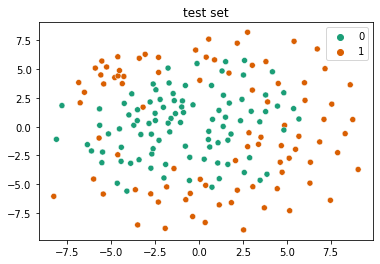

In [ ]:
# MDS for test dataset
sns.scatterplot(x =test_data_transformed_MDS[:,0],y = test_data_transformed_MDS[:,1],hue=test_labels).set(title="test set")
